# DSCI 100 Final Report - Predicting Popularity of Spotify Tracks Using Energy and Danceability Metrics

Team: Nicolas Mercuri, Tayler Whitehead, Stephanie Song, Chris Lukita

# Part 1: Introduction

Music plays a huge role in our experience of the world around us. Daily tasks like walking through campus, working on homework assignments, or simply cooking dinner after a long day are a lot more enjoyable while listening to your favourite playlist.

For our group project this semester, we decided to work with a dataset called [Spotify Tracks DB](https://tinyurl.com/3dnwcpe2). This dataset was downloaded from Kaggle.com and was parsed using Spotify's official API. The dataset has over 110,000 unique observations (tracks) and features 18 relevant variables, each describing a specific qualitative or quantitative characteristic of a track.

For our predictive question, we are asking if specific quantitative characteristics of a track (danceability and energy) can help predict a new song's popularity on the music streaming service, Spotify. To aid us in our analysis, we'll be building and testing a knn regression model tuned to the optimal number of neighbours to predict a song's popularity rating.

We initially chose to use danceability as our predictor for a song's popularity because of Interiano et al.'s (2018) study, which indicates that songs that are more 'danceable' tend to be more successful in terms of ranking high in popularity. Following some of our exploratory data analysis we found that pairing danceability with energy resulted in a lower RMSE than examining danceability on its own, and therefore we decided to use both variables.

While we acknowledge that there is also an array of qualitative factors that contribute to a song's popularity such as culture, seasonality, and personal preference, and therefore must not be dismissed, these qualitative factors affect a song's popularity following its release (Lee & Lee, 2018). Our analysis, then, offers the opportunity to explore how quantitative variables can potentially play a role in predicting the popularity of a song before its initial release. 

# Part 2: Methods and Results

## Reading in Raw Data

First, we load any necessary packages required for our data cleaning and wrangling, initial anlyses, and visualizations.

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(RColorBrewer)

options(repr.plot.width= 30, repr.plot.height= 10)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

We then read in our chosen dataset from our GitHub repository. In order to ensure that our analyses are reproducible, we used the set.seed function (set to an arbitrary number) to generate the same random selection of data throughout our analysis to maintain consistent results.

In [2]:
set.seed(2022)

spotify_raw_data <- read_csv("https://raw.githubusercontent.com/chrislukita/DSCI100-Group-Final/main/data/SpotifyDataset.csv")

Parsed with column specification:
cols(
  genre = col_character(),
  artist_name = col_character(),
  track_name = col_character(),
  track_id = col_character(),
  popularity = col_double(),
  acousticness = col_double(),
  danceability = col_double(),
  duration_ms = col_double(),
  energy = col_double(),
  instrumentalness = col_double(),
  key = col_character(),
  liveness = col_double(),
  loudness = col_double(),
  mode = col_character(),
  speechiness = col_double(),
  tempo = col_double(),
  time_signature = col_character(),
  valence = col_double()
)

Warning message:
“1 parsing failure.
   row col   expected     actual                                                                                             file
115177  -- 18 columns 15 columns 'https://raw.githubusercontent.com/chrislukita/DSCI100-Group-Final/main/data/SpotifyDataset.csv'
”


## Data Wrangling

As our dataset is quite sizeable, we decided to cut our data in half to 50,000 observations. This will enable our analysis to minimize data processing time while still maintaining a considerable amount of information for training and testing our regression model.

In [3]:
set.seed(2022)
spotify_sliced <- slice_sample(spotify_raw_data, n = 50000)

After slicing our data set, we perform some data wrangling to select only our desired columns (popularity, danceability, and energy), as well as omitting any "NA" values that may interfere with our data analysis. These steps help clean up the data by removing any values that are unnecessary for our particular analysis. 

To help with data visualization, we also created popularity groupings which represent a given song's popularity. These groups split all songs into 4 categories: 0 <= 25, 26 <= 50, 51 <= 75, and 76 <= 100. Creating these buckets will help us to create visualizations that use both predictor variables in order to see if any initial trends are present.

In [4]:
spotify_wrangled <- spotify_sliced %>%
                    select(popularity, danceability, energy) %>%
                    na.omit(spotify_wrangled) %>%
                    mutate(popularity_group = case_when(popularity >= 0  & popularity <= 25 ~ '0 <= 25',
                                                        popularity >= 26  & popularity <= 50 ~ '26 <= 50',
                                                        popularity >= 51  & popularity <= 75 ~ '51 <= 75',
                                                        popularity >= 76  & popularity <= 100 ~ '76 <= 100'))

## Exploratory Visualization of the Data

With our data grouped into four buckets, we create a dataframe and visualization that represents the count of songs within each popularity band.

`summarise()` ungrouping output (override with `.groups` argument)



popularity_group,count
<chr>,<int>
0 <= 25,10150
26 <= 50,19411
51 <= 75,19442
76 <= 100,997


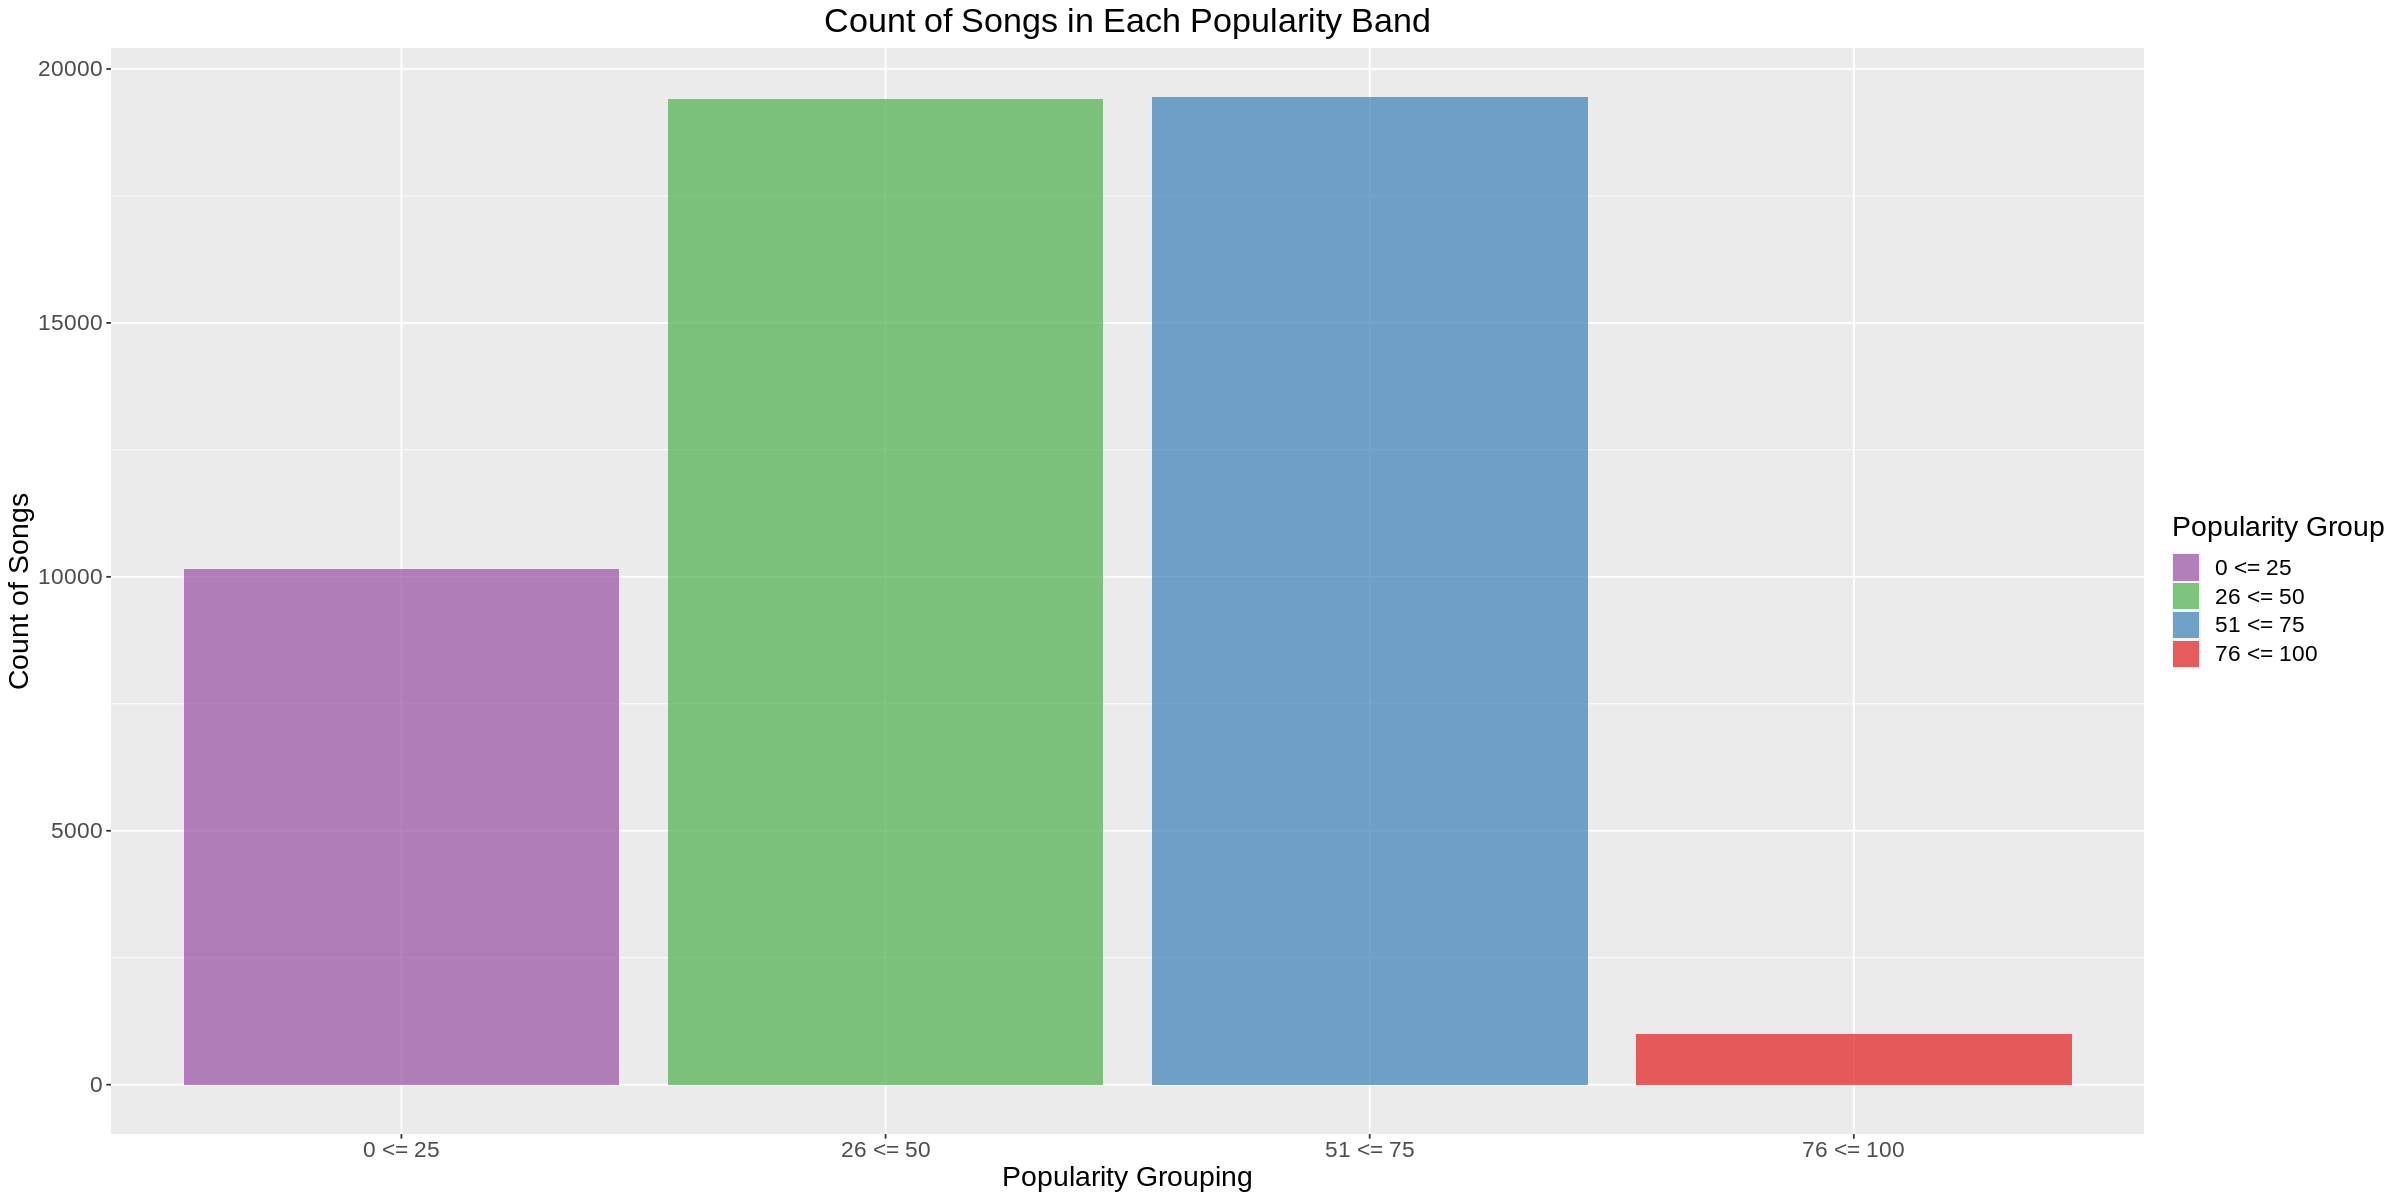

In [5]:
options(repr.plot.width= 20, repr.plot.height= 10)

spotify_grouped_by_popularity <- spotify_wrangled %>%
                        group_by(popularity_group) %>%
                        summarize(count = n())

spotify_grouped_by_popularity


spotify_count_plot <- spotify_grouped_by_popularity %>%
                        ggplot(aes(x = popularity_group, y = count, fill = popularity_group)) + 
                        geom_bar(alpha = 0.7, stat = "identity") + 
                        labs(x = "Popularity Grouping", y = "Count of Songs", fill = "Popularity Group") +
                        ggtitle("Count of Songs in Each Popularity Band") +
                        theme(plot.title = element_text(hjust = 0.5)) +
                        scale_fill_brewer(palette = "Set1", direction=-1) +
                        theme(text=element_text(size=17))

spotify_count_plot

*Table 1 & Figure 1* : Visualizing counts of songs within each popularity group

The bar graph indicates that within our sample of 50000 songs, the vast majority fall between a popularity rating of 26-75 suggesting that it is rare to make a song that is considered very popular according to Spotify's metric.

From here, we slice a small sample (n = 1000) of the entire dataset and create a scatter plot to determine if there are any trends we can extrapolate from the plot.

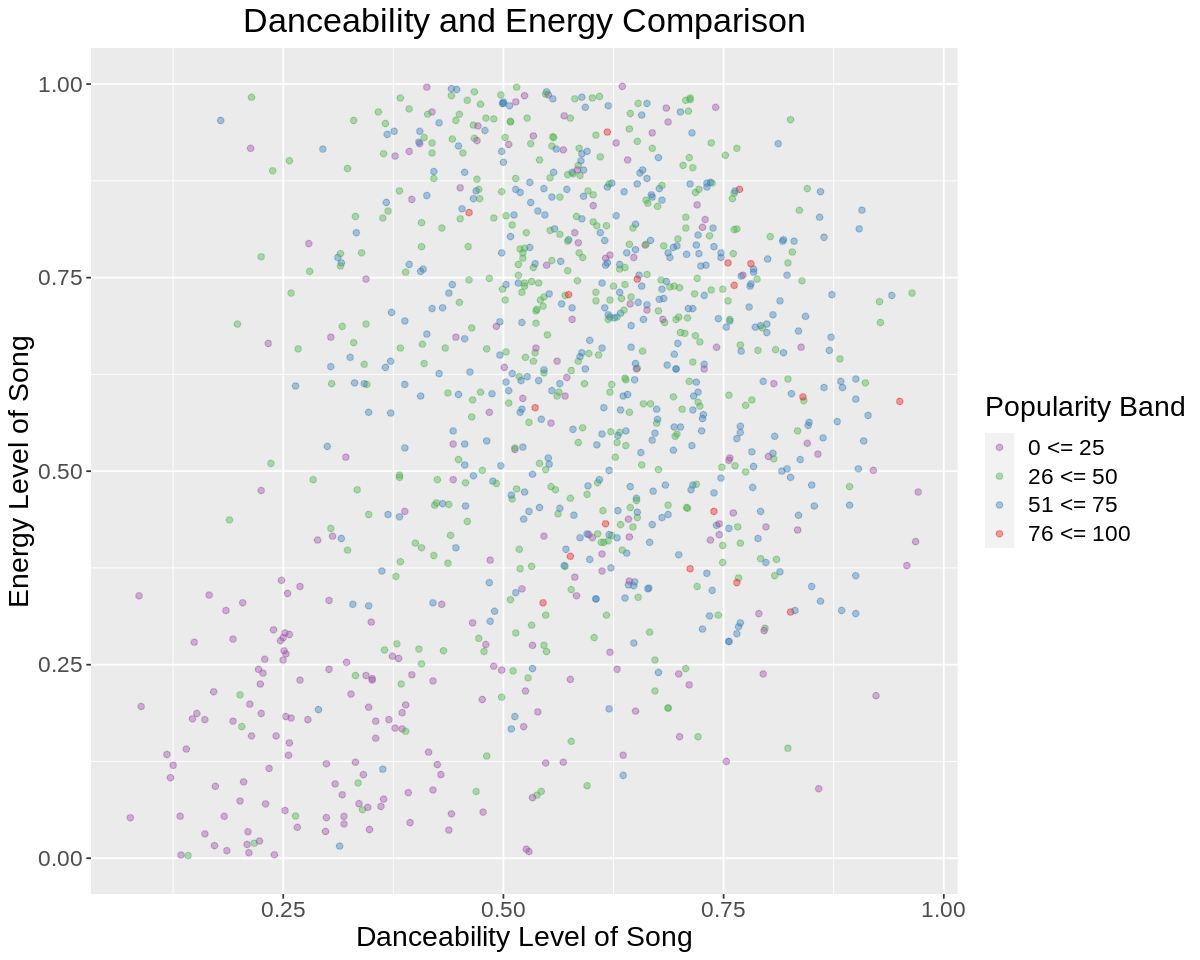

In [6]:
set.seed(2022)
options(repr.plot.width= 10, repr.plot.height= 8)

spotify_really_small <- slice_sample(spotify_wrangled, n = 1000)

danceability_vs_popularity <- spotify_really_small %>%
                                ggplot(aes(x = danceability, y = energy, color = popularity_group)) + 
                                geom_point(alpha = 0.4) + 
                                labs(y = "Energy Level of Song", x = "Danceability Level of Song", color = "Popularity Band") +
                                ggtitle("Danceability and Energy Comparison") +
                                theme(plot.title = element_text(hjust = 0.5)) +
                                scale_color_brewer(palette = "Set1", direction=-1) +
                                theme(text=element_text(size=17))
                                   
danceability_vs_popularity                         

*Figure 2* : Visualizing patterns between predictors and the response variable

From the visualization, we can see that the most unpopular tracks (0 <= 25) tend to cluster in the bottom left quadrant of the graph where danceability and energy levels < 0.50. However, after that it is difficult to make any meaningful conclusions.

## Creating Training Data

Now that we have our relevant popularity buckets, we can create our training dataset which comprises 75% of the total wrangled Spotify dataset. The remaining 25% will be used as our testing dataset.

In [7]:
set.seed(2022)
spotify_split <- initial_split(spotify_wrangled, prop = 0.75, strata = popularity)

spotify_train <- training(spotify_split)
spotify_test <- testing(spotify_split)

## Summarizing the Data

Here we provide the summary statistics for our selected variables. It should be noted that popularity is measured on a scale from 0-100, and danceability and energy have been standardized to a scale of 0-1. 

In [8]:
summary(spotify_train)

   popularity     danceability        energy         popularity_group  
 Min.   :  0.0   Min.   :0.0592   Min.   :0.000243   Length:37501      
 1st Qu.: 30.0   1st Qu.:0.4510   1st Qu.:0.407000   Class :character  
 Median : 47.0   Median :0.5770   Median :0.615000   Mode  :character  
 Mean   : 42.8   Mean   :0.5662   Mean   :0.586198                     
 3rd Qu.: 57.0   3rd Qu.:0.6960   3rd Qu.:0.797000                     
 Max.   :100.0   Max.   :0.9890   Max.   :0.999000                     

*Table 2* : Summary statistics for our relevant variables in the spotify music dataset.

## Visualizing the Data

To visualize our data, we will create histograms to show the distribution of values of our main predictive variables: danceability and energy.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



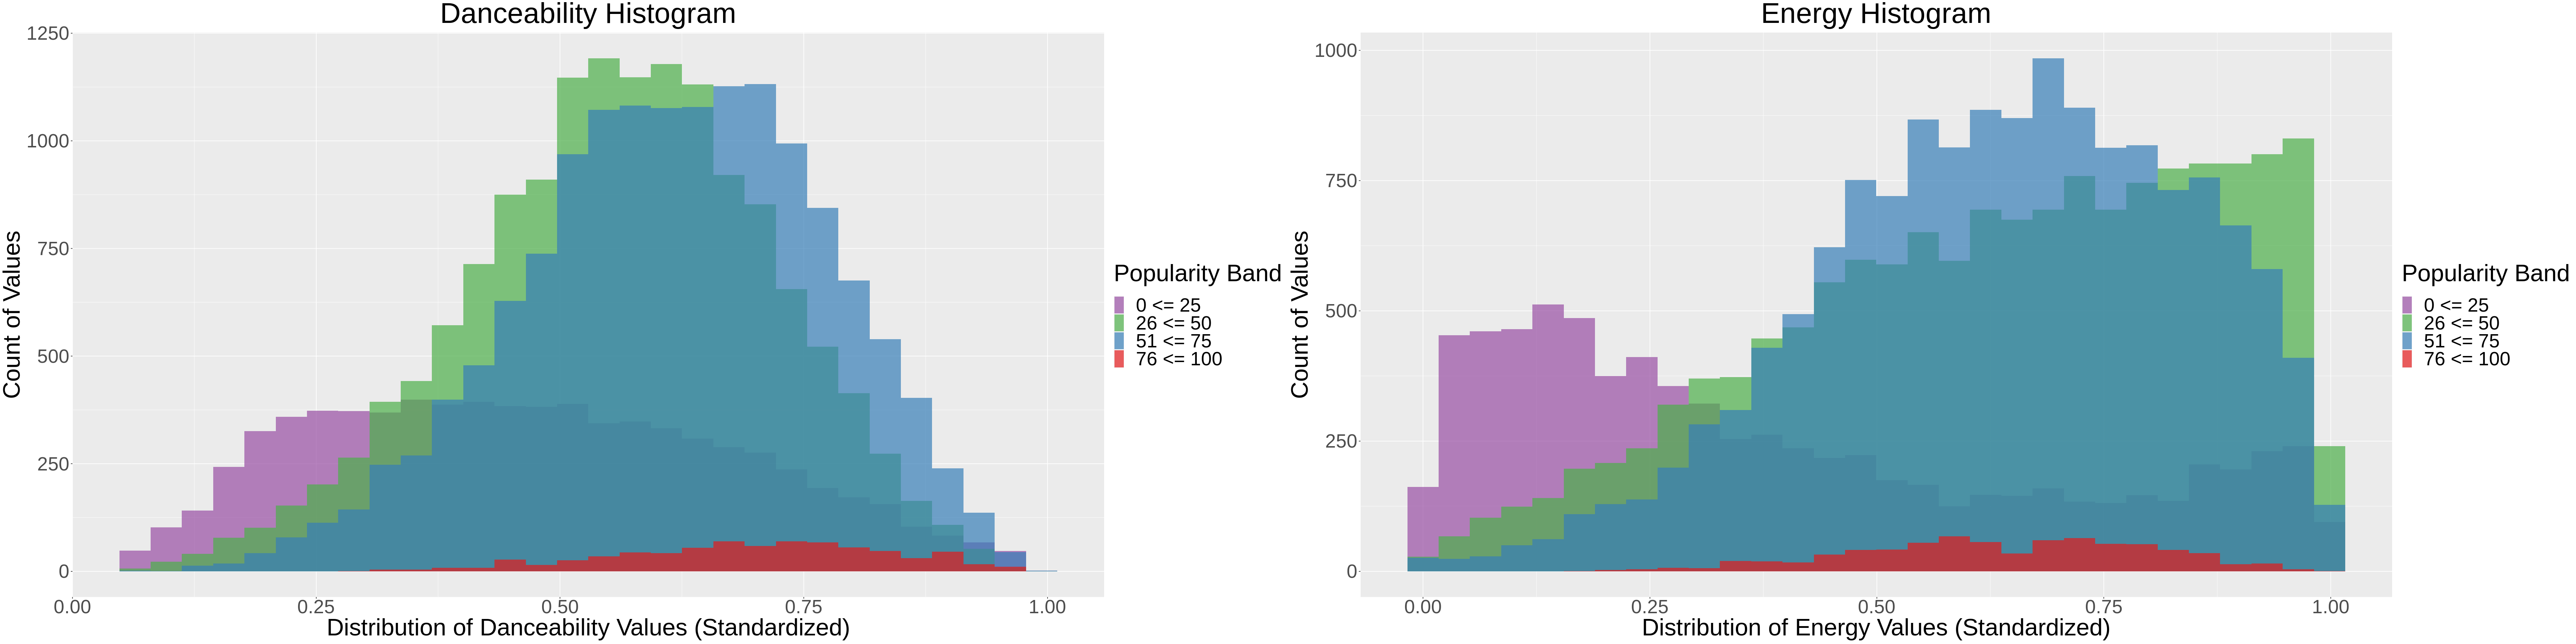

In [9]:
options(repr.plot.width= 60, repr.plot.height= 15)

danceability_histogram <- spotify_train %>%
                        ggplot(aes(x = danceability, fill = popularity_group)) +
                        geom_histogram(alpha = 0.7, position = "identity") +
                        labs(x = "Distribution of Danceability Values (Standardized)", y = "Count of Values"
                            , fill = "Popularity Band") + 
                        ggtitle("Danceability Histogram") +
                        theme(text = element_text(size = 40), plot.title = element_text(hjust = 0.5)) + 
                        scale_fill_brewer(palette = "Set1", direction=-1)
                        
energy_histogram <- spotify_train %>%
                        ggplot(aes(x = energy, fill = popularity_group)) +
                        geom_histogram(alpha = 0.7, position = "identity") +
                        labs(x = "Distribution of Energy Values (Standardized)", y = "Count of Values"
                             , fill = "Popularity Band") + 
                        ggtitle("Energy Histogram") +
                        theme(text = element_text(size = 40), plot.title = element_text(hjust = 0.5)) + 
                        scale_fill_brewer(palette = "Set1", direction=-1)

plot_grid(danceability_histogram, energy_histogram, ncol = 2)

*Figure 3.1 & 3.2* : Histograms showing how songs within each popularity group are influenced by changes in danceability (left) and energy (right).

We can see that the danceability values follow a relatively normal distribution, while the energy distribution is skewed to the left. From the visualizations, we can see that as danceability and energy levels increase, the proportion of unpopular songs (0 <= 25 on popularity) tends to decrease, while the other popularity bands tend to increase. It should be noted as well that the most popular songs (rating 76 <= 100) generally have danceability and energy values above 0.25 with most songs being above 0.5. 

## Data Analysis

**How will we conduct our data analysis?**

Our data analysis will adhere to the following structure and format:
- Step #1 - Develop our KNN recipe.
- Step #2 - Build our nearest neighbors model specification, ensuring that the neighbors parameter is set to tune().
- Step #3 - Utilize the vfold_cv function to split our training data for cross-validation.
- Step #4 - Create workflow using the recipe and model developed in steps 2 and 3.
- Step #5 - Choose an optimal K value from this workflow analysis.
- Step #6 - Develop a new model specification using the optimal value for K, and then retrain the regression model using fit.
- Step #7 - Evaluate accuracy using the testing data.
- Step #8 - Develop visualizations that summarize our analysis, and draft any documentation required to aid understanding of our processes.

**Tuning model to find best K value using two predictors**

Here we create our model's recipe using the training data set, where we indicate the response variable and the desired predictors. In the recipe we also scale and center the data so that the values are being compared using relative scales and metrics to avoid  one or more of the variables exhibiting disproportionate influence on the model's outputs.

In [10]:
spotify_recipe <- recipe(popularity ~ danceability + energy, data = spotify_train) %>%
                        step_scale(all_predictors()) %>%
                        step_center(all_predictors())

spotify_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Scaling for all_predictors()
Centering for all_predictors()

Next, we create the model specifications using the knn algorithm for regression which predicts the response variable's value based on the values of neighbouring points. Since, we want to find the optimal value of neighbours that reduces our model's RMSE, we set neighbours to "tune()" while we continue to train the model.

In [11]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn") %>%
            set_mode("regression")

From here, we create a 5-fold cross-validation object to test the performance of various k values ranging from 1-100 by 3. Subsequently, we put the recipe and model specification together in a workflow and filter the RMSE values of each k value to create a plot of RMSE vs. number of neighbours.

In [12]:
set.seed(2022)
spotify_vfold <- vfold_cv(spotify_train, v = 5, strata = popularity)

gridvals <- tibble(neighbors = seq(from = 1, to = 100, by = 3))

In [13]:
set.seed(2022)
spotify_results <- workflow() %>%
                      add_recipe(spotify_recipe) %>%
                      add_model(knn_tune) %>%
                      tune_grid(resamples = spotify_vfold, grid = gridvals) %>%
                      collect_metrics() %>%
                    filter(.metric == "rmse")

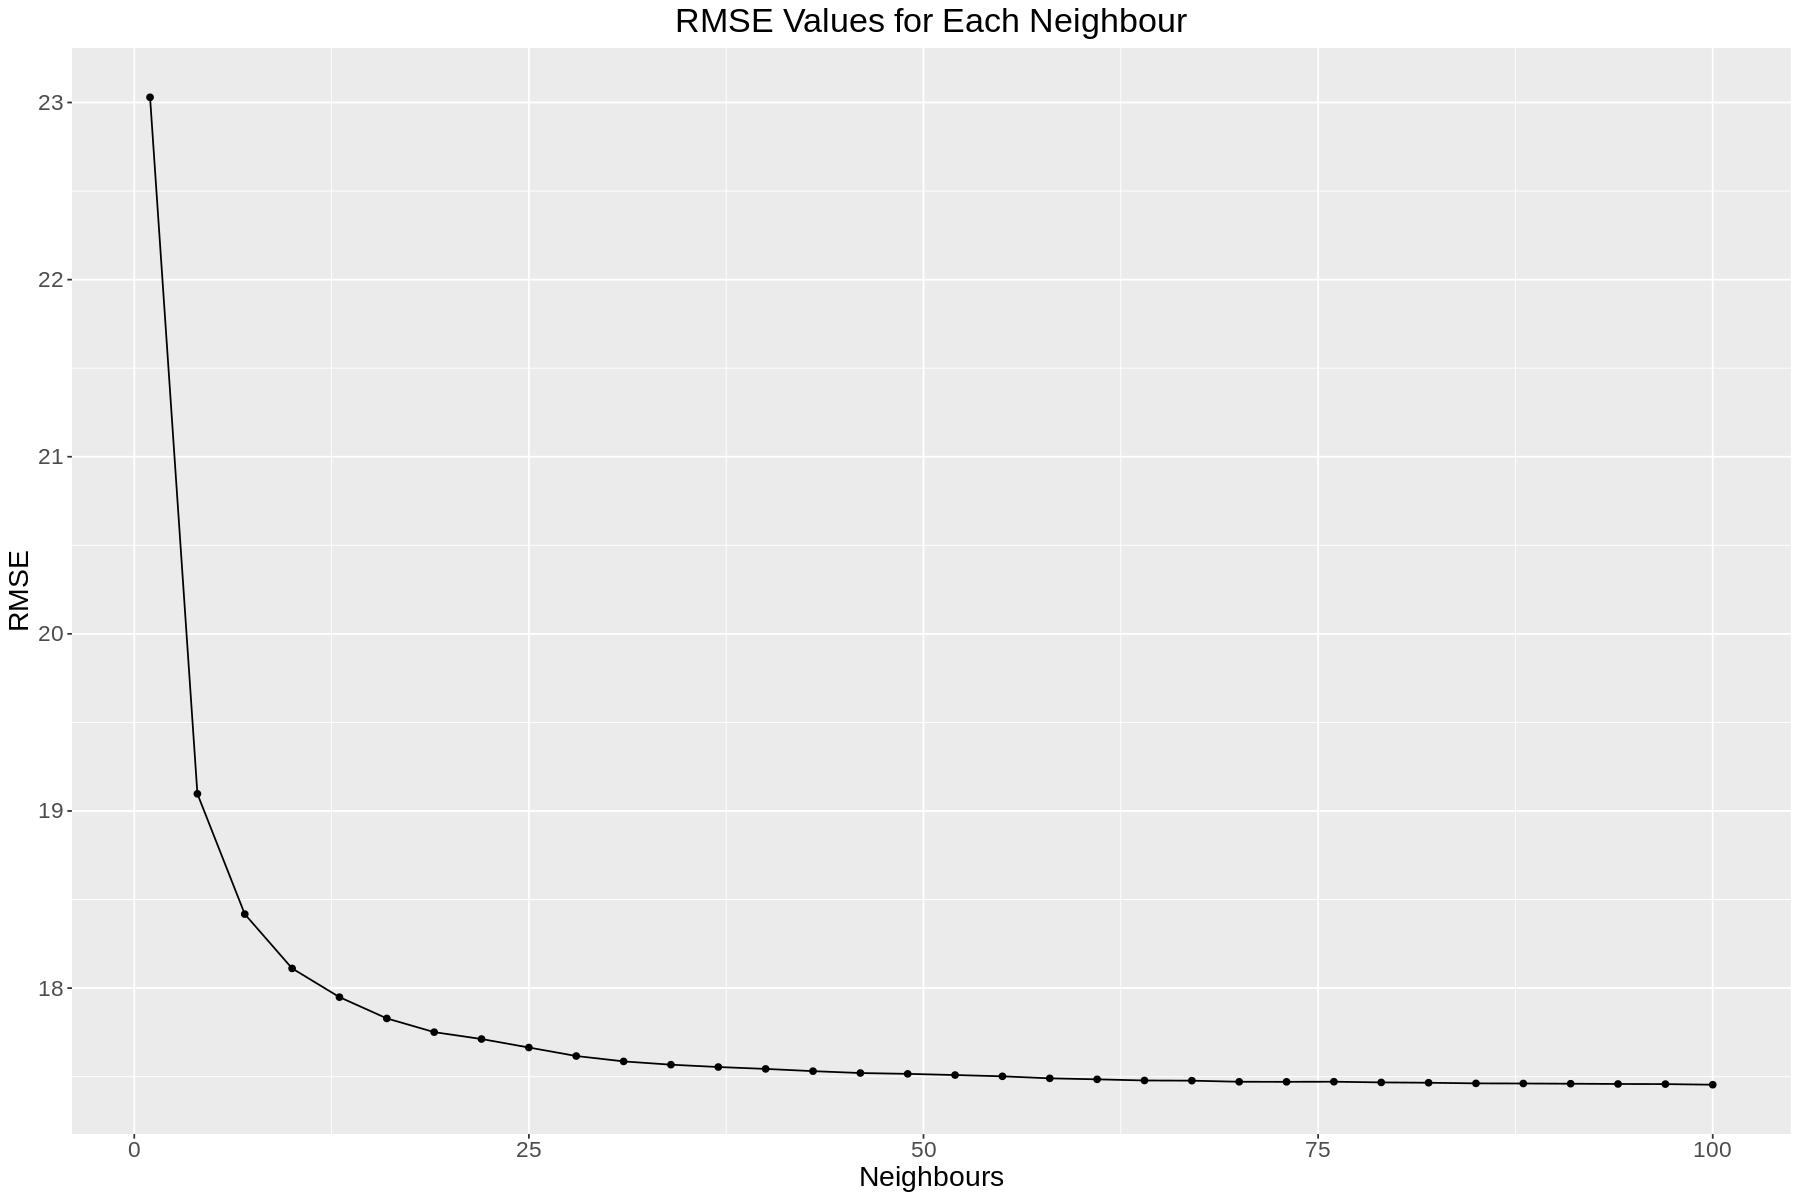

In [14]:
options(repr.plot.width= 15, repr.plot.height= 10)

spotify_results_plot <- spotify_results %>% 
                            ggplot(aes(x = neighbors, y = mean)) +
                            geom_point() +
                            geom_line() +
                            labs(x = "Neighbours", y = "RMSE") +
                            ggtitle("RMSE Values for Each Neighbour") +
                            theme(plot.title = element_text(hjust = 0.5)) +
                            theme(text=element_text(size=17))

spotify_results_plot

*Figure 4* : Visualizing RMSE in relation to number of neighbours (1-100).

We can see from the plot that the RMSE continues to decrease as the number of neighbours increases. We can gather from this that the optimal number of neighbours is likely much beyond 100 therefore, we continue to plot neighbours beyond 100, to 300.

In [15]:
set.seed(2022)
gridvals_increased <- tibble(neighbors = seq(from = 101, to = 300, by = 3))

spotify_results_increased <- workflow() %>%
                              add_recipe(spotify_recipe) %>%
                              add_model(knn_tune) %>%
                              tune_grid(resamples = spotify_vfold, grid = gridvals_increased) %>%
                              collect_metrics() %>%
                              filter(.metric == "rmse")

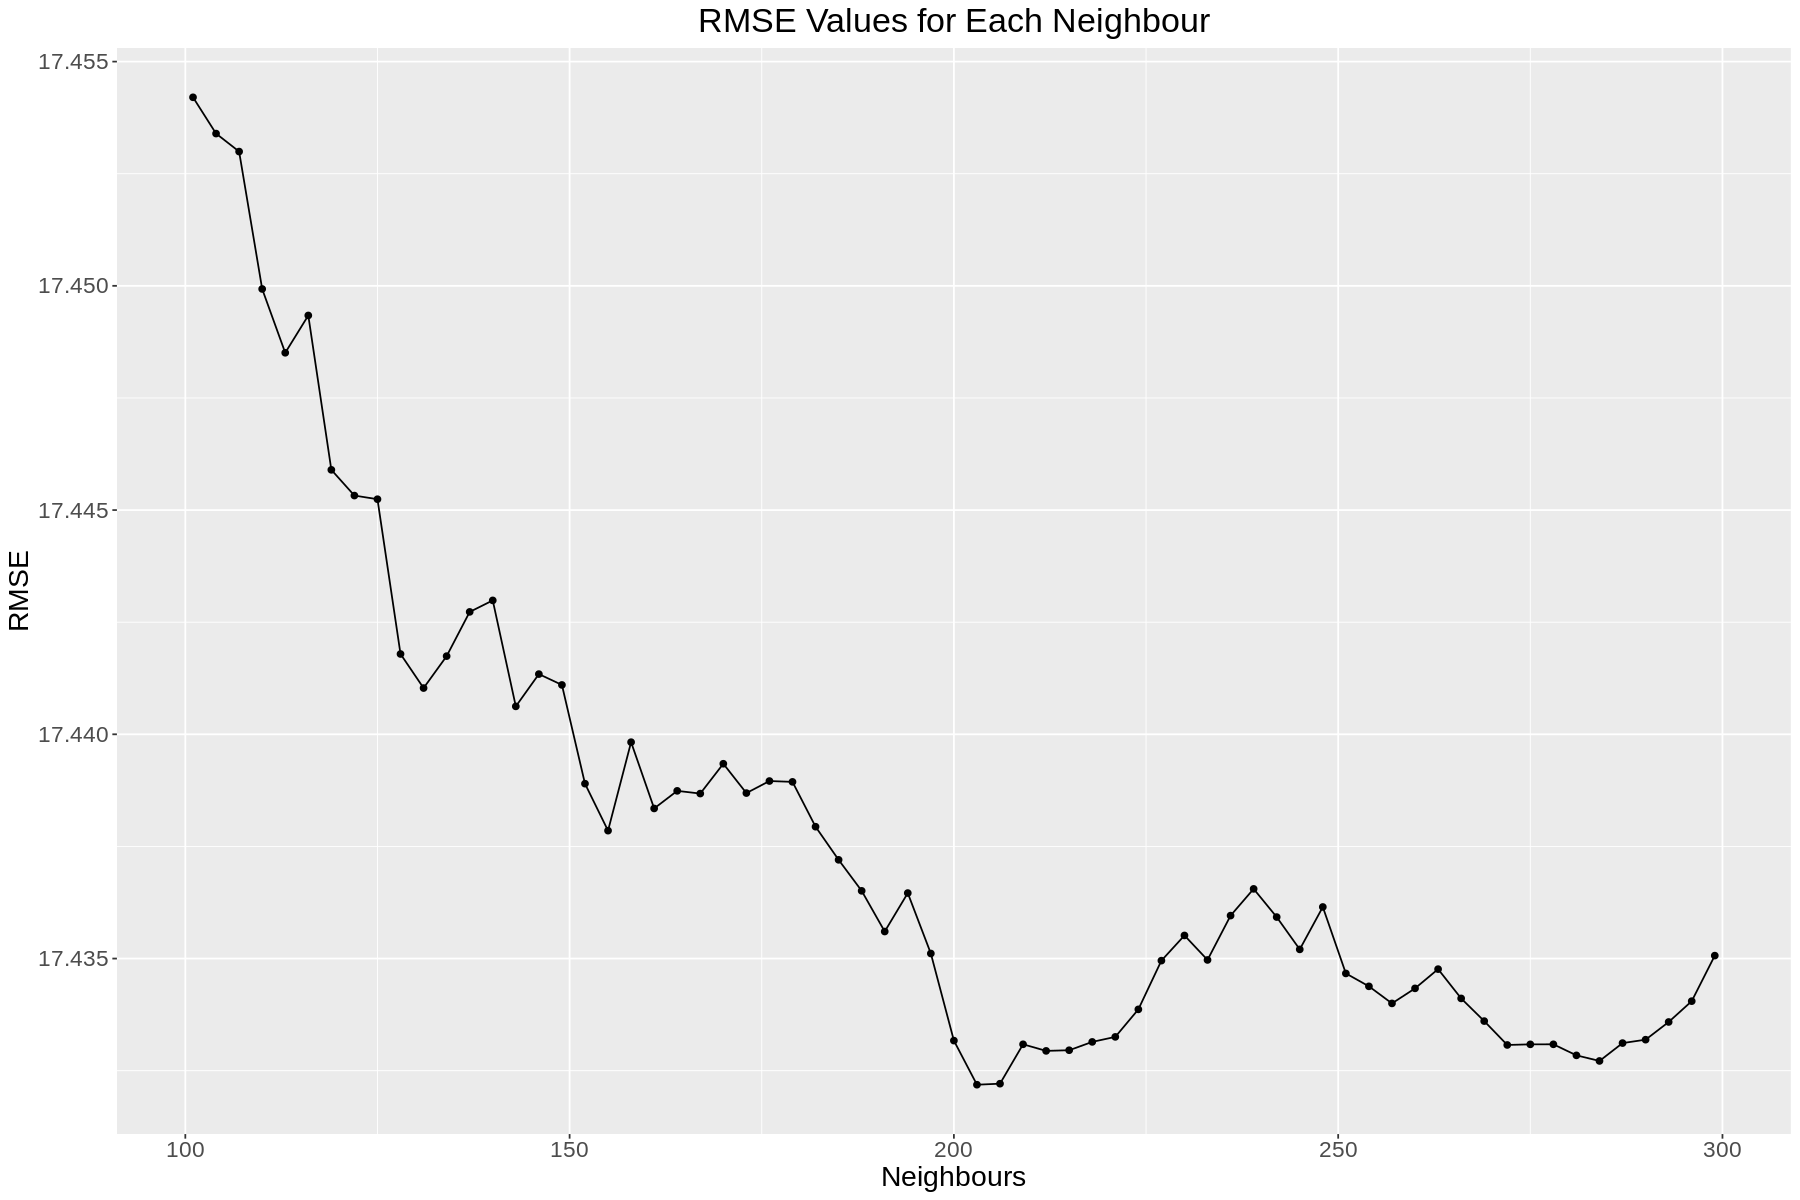

In [16]:
options(repr.plot.width= 15, repr.plot.height= 10)

spotify_results_increased_plot <- spotify_results_increased %>% 
                                    ggplot(aes(x = neighbors, y = mean)) +
                                    geom_point() +
                                    geom_line() +
                                    labs(x = "Neighbours", y = "RMSE") +
                                    ggtitle("RMSE Values for Each Neighbour") +
                                    theme(plot.title = element_text(hjust = 0.5)) +
                                    theme(text=element_text(size=17))

spotify_results_increased_plot

*Figure 5* : Visualizing RMSE in relation to number of neighbours (101-300).

Now that we can see that the RMSE increases at around 200 neighbours, we can filter RMSE for the smallest value and select its associated k-value to re-train our model.

In [17]:
spotify_rmse <- spotify_results_increased %>% 
                    filter(.metric == "rmse") %>%
                    filter(mean == min(mean))

spotify_rmse

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
203,rmse,standard,17.43219,5,0.08779373,Model35


*Table 3* : Data frame indicating the neighbour with the lowest RMSE value.

Based on this information, we can be reasonably confident that using 203 neighbours for our knn regression analysis will result in the most precise predictions.

We now re-train our knn regression model using 203 neighbours and make predictions using the testing set we created earlier.

In [18]:
spotify_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 203) %>%
                    set_engine("kknn") %>%
                    set_mode("regression")

spotify_fit <- workflow() %>%
                    add_recipe(spotify_recipe) %>%
                    add_model(spotify_spec) %>%
                    fit(data = spotify_train)

spotify_summary <- predict(spotify_fit, spotify_test) %>%
                        bind_cols(spotify_test) %>%
                        metrics(truth = popularity, estimate = .pred) %>%
                        filter(.metric == "rmse")

spotify_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,17.50218


*Table 4* : Data frame indidcating our model's RMSPE value based on the testing data set created earlier.

The resulting RMSPE value is 17.50, indicating that our knn regression model will predict a new song's popularity rating with the possibility of its true rating being +/- 17.50 units on a 100-point popularity scale.

## Visualizing our Analysis

In order to interpret these results further, we now visualize how well our predictors map to our response variable by creating scatterplots with a line of best fit that represents our model's predictions.

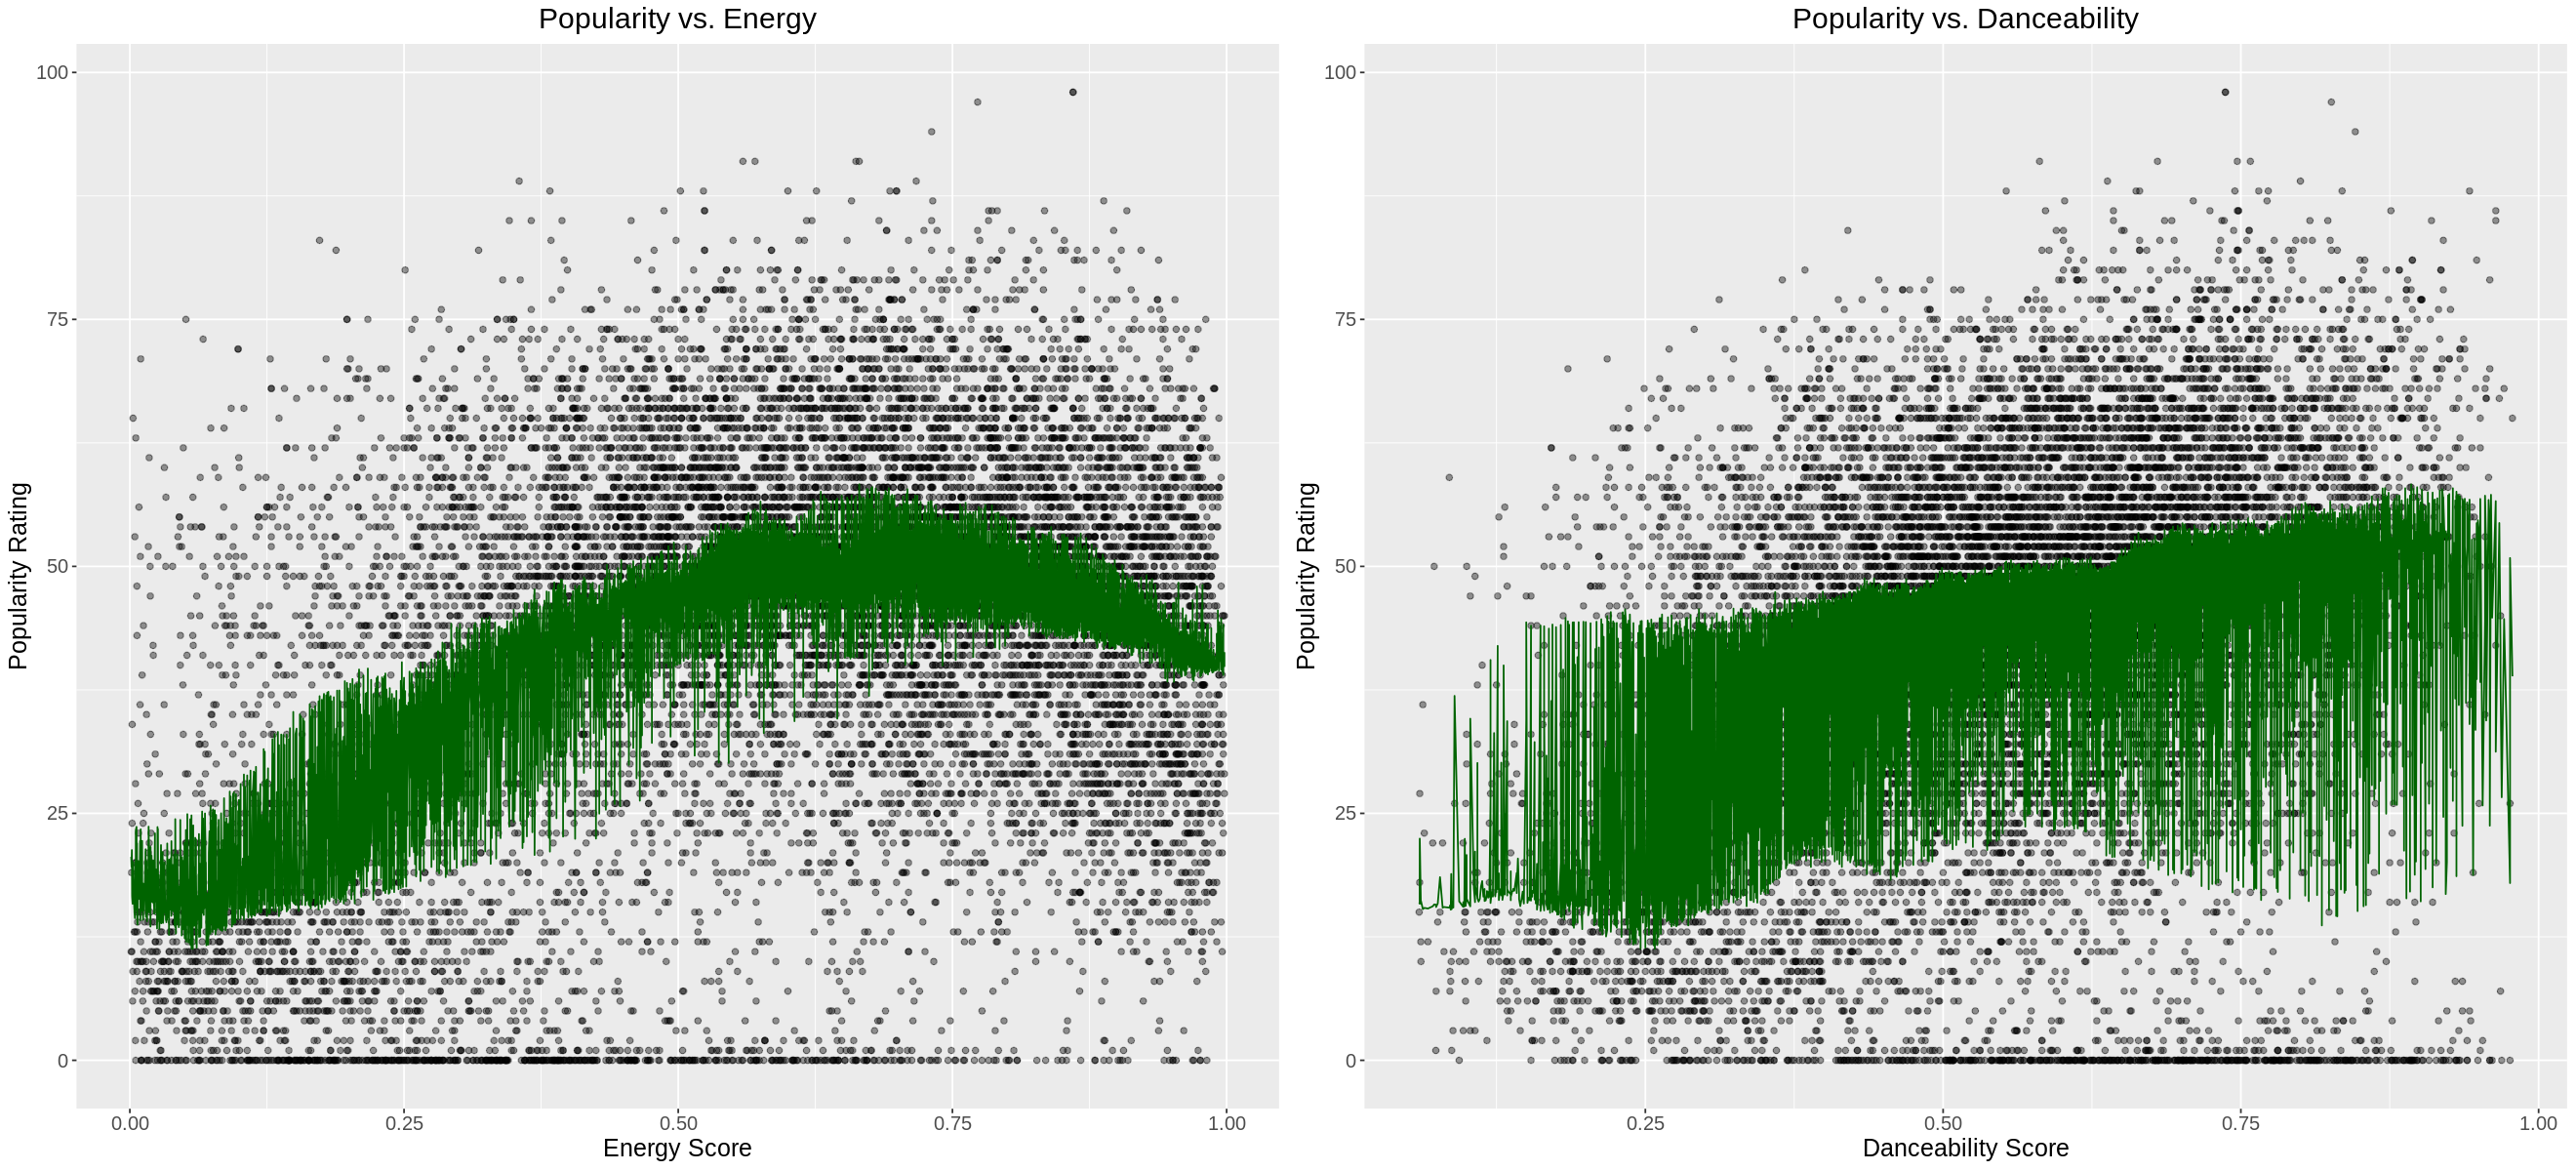

In [19]:
options(repr.plot.width= 22, repr.plot.height= 10)

spotify_summary <- predict(spotify_fit, spotify_test) %>%
                        bind_cols(spotify_test) 

danceability_plot <- ggplot(spotify_summary, aes(x=danceability, y=popularity)) + 
                        geom_point(alpha=0.4) +
                        geom_line(aes(x=danceability, y=.pred), color = "darkgreen") +
                        labs(x="Danceability Score", y="Popularity Rating") +
                        ggtitle("Popularity vs. Danceability") +
                        theme(text=element_text(size=15)) +
                        theme(plot.title = element_text(hjust = 0.5)) 

energy_plot <- ggplot(spotify_summary, aes(x=energy, y=popularity)) + 
                        geom_point(alpha=0.4) +
                        geom_line(aes(x=energy, y=.pred), color = "darkgreen") +
                        labs(x="Energy Score", y="Popularity Rating") +
                        ggtitle("Popularity vs. Energy") +
                        theme(text=element_text(size=15)) +
                        theme(plot.title = element_text(hjust = 0.5))

plot_grid(energy_plot, danceability_plot, ncol = 2)

*Figure 6.1 & 6.2* : Plots illustrating line of best fit for both our predictors (Energy left) (Danceability right).

Figure 6.1 illustrates a distinguishable pattern in the data where a song's popularity increases with energy until around an energy score of ~0.75 where it drops off slightly. Our prediction model appears to capture this trend fairly well. In figure 6.1 we see that a song's popularity generally increases with danceability indefinitely, however our prediction model does not pick up on this trend strongly and appears to be overfitted.  

Ideally, we would have liked to create our knn regression model with more neighbours in order to prevent overfitting, as illustrated in the figures above. This may have reduced some of the jaggedness of the prediction line plot, however, Jupyter continually crashed whenever we tried increasing the number of neighbours. As a result, this is the best prediction model we could build given the circumstances. It is likely then that our model is influenced by the training data more than we had desired.

### Discussion

**What did we find?**

From our initial exploration of the data, we found that generally the most unpopular songs (those with popularity ratings of 25 or less) had danceability and energy ratings under 0.5. Very few songs that had popularity ratings between 51 and 75 had danceability and energy values below 0.5. This led us to believe that a song's danceability and energy levels may have some influence on its popularity. Considering our model's test predictions resulted in a RMSPE of 17.50, our analysis indicates that energy and danceability metrics are reasonable to consider in predicting a new song's popularity but should not be the only features of a song that are examined. An RMSPE of 17.50 is not negligible in the context of a response variable with values only ranging from 0-100. As a result, our model may be useful in providing an estimated baseline for predicting a song's popularity which can perhaps be improved by also incorporating qualitative features, such as the song's mood and genre.

Due to our exploratory analyses revealing subtle patterns that may suggest the predictive ability of our two predictive variables and the support of Interiano et al.'s (2018) paper, we expected our knn regression model to produce more precise predictions as we expected there to be an inherent positive relationship between a song's popularity, energy, and danceability. However, this result is not entirely unforeseen either as we were unable to create a model using a higher k-value and because we recognize that there are many features, both qualitative and quantitative, that contribute to notions of popularity and thus it may have been unrealistic to suppose that our two quantitative variables could predict a song's popularity alone.

**What impact could these findings have?**

Our findings could help artists and producers understand the metrics that make music listeners really connect with a song. Making music is both an art and a science, and we hope that our analysis can provide artists and producers with the potential to uncover insights to help them create new music that will resonate with listeners on Spotify and other streaming services. Our findings also have the potential to be used in combination with marketing strategies whereby marketing teams may want to consider using songs that are predicted to be popular in their advertisements in order to entice consumers even more (Lee & Lee, 2018).

**What future questions could this lead to?**

As this dataset is unique to the listening habits of Spotify users, it would be interesting to compare these results with data from other popular streaming services, like Apple Music, Amazon Music, and Youtube Music, respectively, to see if the metrics reported on these music streaming services provide similar results. There is also opportunity to analyze the relationship between song popularity and other quantitative metrics not considered in this project. Furthermore, it may also be interesting to research the role these metrics play in current music production to determine if artists and producers already consider these metrics when creating new songs. 

### References

Hamidani, Z. (2019). *Spotify Tracks DB* [Data set]. Kaggle. https://www.kaggle.com/datasets/zaheenhamidani/ultimate-spotify-tracks-db

Interiano, M., Kazemi, K., Wang, L., Yang, J., Yu, Z., & Komarova, N. L. (2018). Musical trends and predictability of success in contemporary songs in and out of the top charts. *Royal Society Open Science, 5*(5), 171274-171274. https://doi.org/10.1098/rsos.171274

Lee, J., & Lee, J. (2018). Music popularity: Metrics, characteristics, and audio-based prediction. *IEEE Transactions on Multimedia, 20*(11), 3173-3182. https://doi.org/10.1109/TMM.2018.2820903